In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
!pip install tld
!pip install googlesearch-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import os
import os.path
import re
import pickle

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from urllib.parse import urlparse
from googlesearch import search
from tld import get_tld

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization ,Activation
from keras.callbacks import ModelCheckpoint

In [153]:
# read the file
path = '/content/malicious_phish.csv'
df = pd.read_csv(path)
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [154]:
# Count the value of url type
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [155]:
print(df.shape)

(651191, 2)


The dataset has 651,191 records with two columns URLs and type of those URLs.

In [156]:
# Create dataframe correspond to its type
df_phishing = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_defacement = df[df.type=='defacement']
df_benign = df[df.type=='benign']

We will create wordcloud for each URLs type as follow:

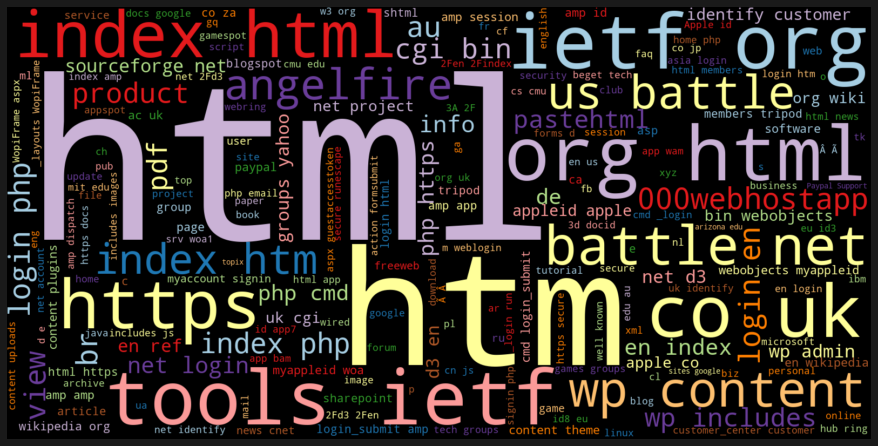

In [157]:
# Plot the wordcloud for phishing URLs
phish_url = " ".join(i for i in df_phishing.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

The frequent tokens of phishing URLs are html, org, html, ietf, tools, battle.

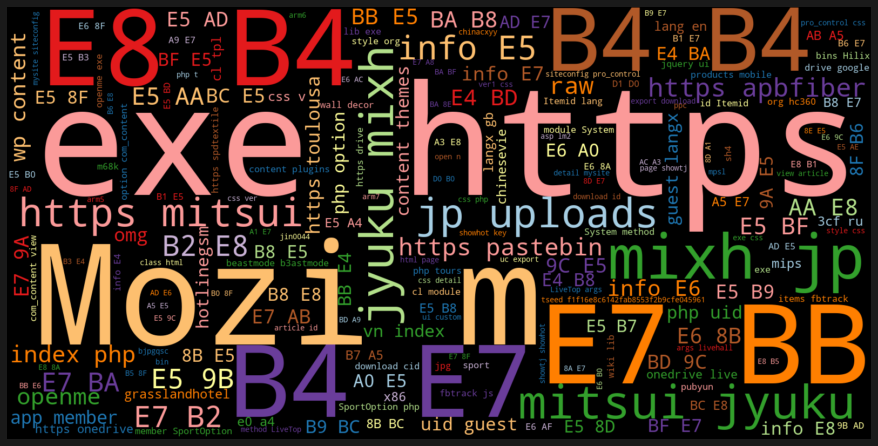

In [158]:
# Plot the wordcloud for malware URLs
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

The frequent tokens of malware URLs are E7, BB, exe, https, Mozi, B4, etc.

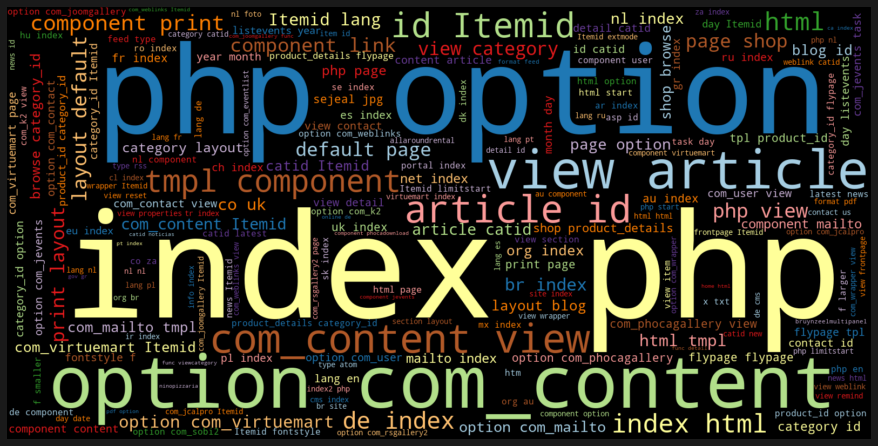

In [159]:
# Plot the wordcloud for defacement URLs
deface_url = " ".join(i for i in df_defacement.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

The frequent tokens of defacement URLs are index, php, view article, php option.

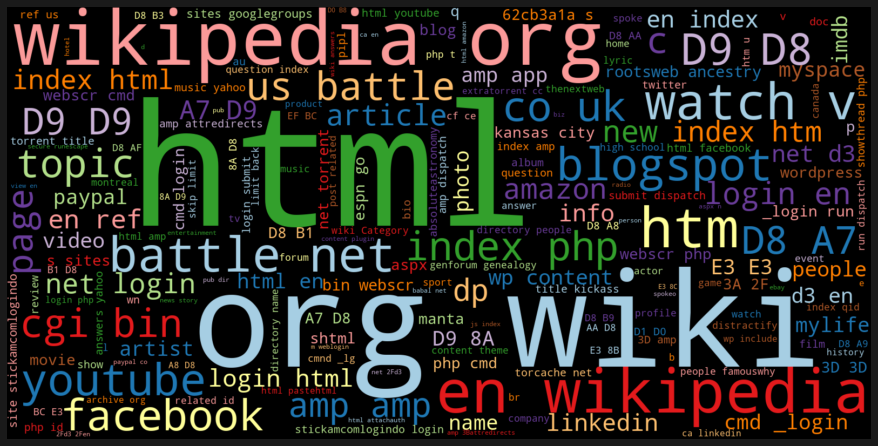

In [160]:
# Plot the wordcloud for benign URLs
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

The frequent tokens of benign URLs are index, php, view article, php option.

In [161]:
"""
The hacker will use IP instead of domain name to hide their identity
so this function will check if there is an IP or not in domain.
 
"""
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))


In [162]:
"""
For a unharmful website, the identity is part of the URL

"""
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

We then check if the URL has been indexed by google or not

In [163]:
# Check google index of the website
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [164]:
# Check the dot in the URLs
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

In [165]:
# Count the www in the URLs. 
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

In [166]:
# Count the @ in the URLs
def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))

In [167]:
# Count the directories path in the URLs
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

In [168]:
# Count the "//" in the URLs 
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))

In [169]:
# Check if the URLs has shorten URLs
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
        
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [170]:
# Count the https in the URLs
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

In [171]:
# Count the http in the URLs
def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [172]:
# Count the percentage in the URLs
def count_percentage(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_percentage(i))

In [173]:
# Count the question mark in the URLs
def count_question(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_question(i))

In [174]:
# Count the hyphen in the URLs
def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

In [175]:
# Count the equal "="" in the URLs
def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

In [176]:
# Check the length of the URLs
def url_length(url):
    return len(str(url))

df['url_length'] = df['url'].apply(lambda i: url_length(i))

In [177]:
# Check the hostname length of the URLs
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

In [178]:
# Check the suspicious words in the URLs
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df['suspicious_url'] = df['url'].apply(lambda i: suspicious_words(i))

In [179]:
# Count the digit numbers in the URLs
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))

In [180]:
# Count the letters in the URLs
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [181]:
# Check the first Directory Length of the URLs
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

In [182]:
# Check the length of Top Level Domain of the URLs
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [183]:
# Drop the tld column
df = df.drop("tld",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [184]:
# Check the columns
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'suspicious_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [185]:
# Count number of columns
len(df.columns)

24

Totally we created 22 features.

In [186]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count?,count-,count=,url_length,hostname_length,suspicious_url,count-digits,count-letters,fd_length,tld_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,1,0,16,0,0,0,13,0,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,35,0,0,1,29,5,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,31,0,0,1,25,7,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,1,4,88,21,0,7,63,9,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,1,3,235,23,0,22,199,9,3


In [187]:
# Let's pickle df 
df.to_pickle('df.pkl')

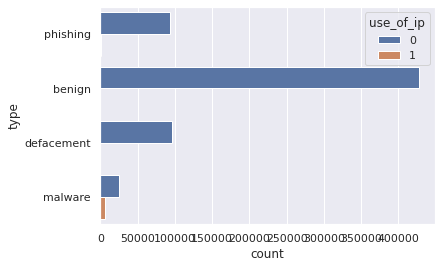

In [188]:
# Check the use of IP in four classes
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

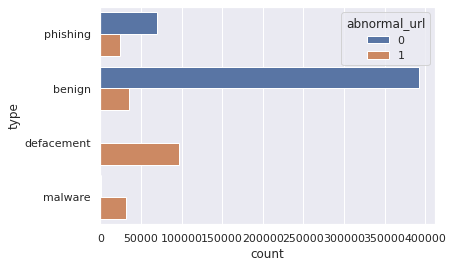

In [189]:
# Check the abnormal URLs in four classes
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")


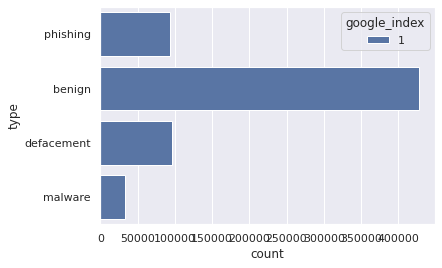

In [190]:
# Check the google index in four classes
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

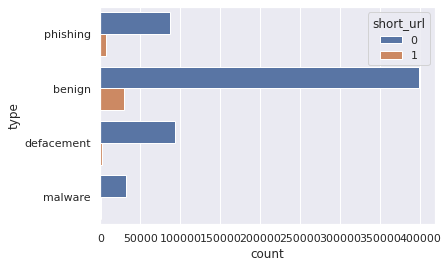

In [191]:
# Check the short url in four classes
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

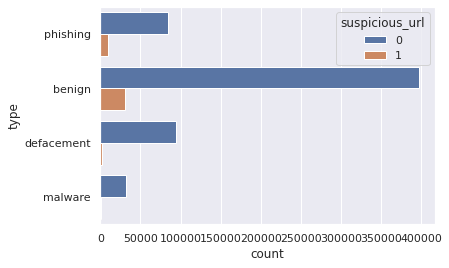

In [192]:
# Check the suspicious url in four classes
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="suspicious_url")

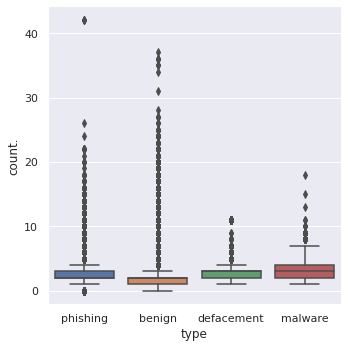

In [193]:
# Check the count dot in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

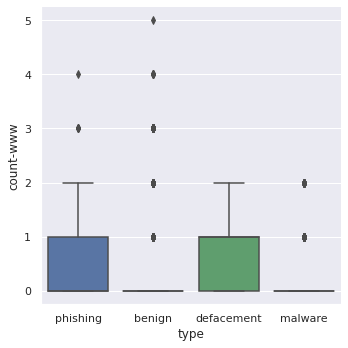

In [194]:
# Check the count www in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

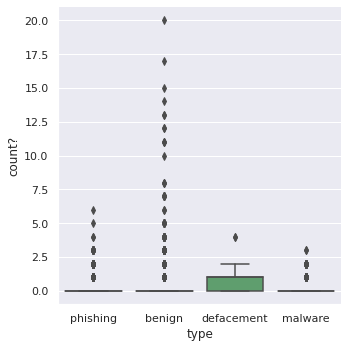

In [195]:
# Check the count ? in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count?", kind="box", data=df)

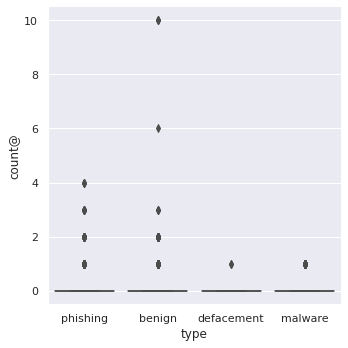

In [196]:
# Check the count @ in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count@", kind="box", data=df)

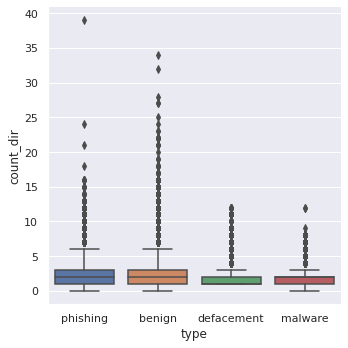

In [197]:
# Check the count directory in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

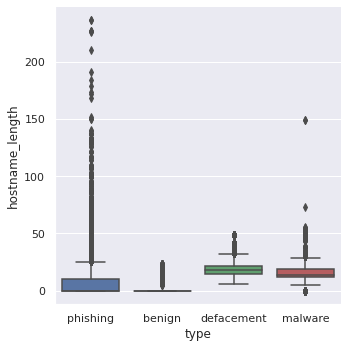

In [198]:
# Check the hostname length in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

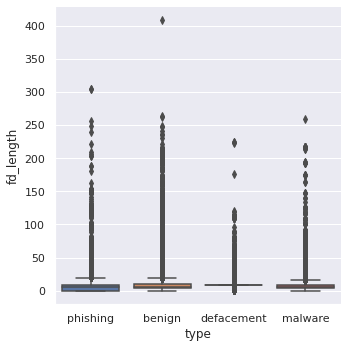

In [199]:
# Check the first Directory Length in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

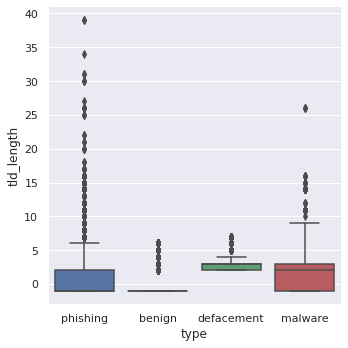

In [200]:
# Check the length of Top Level Domain in four classes
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

In [201]:
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [202]:
# Check the google index value
df.google_index.value_counts()

1    651191
Name: google_index, dtype: int64

Since the google_index feature has only 1 value so we will filter it out from the feature columns since it won't contribute for the training model

In [203]:
#Predictor Variables
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'suspicious_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [204]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,suspicious_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [205]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'suspicious_url', 'fd_length', 'tld_length',
       'count-digits', 'count-letters'],
      dtype='object')

In [206]:
len(X.columns)

21

In [207]:
y.head()

0    3
1    0
2    0
3    1
4    1
Name: type_code, dtype: int64

In [208]:
y.dtypes

dtype('int64')

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=42)

In [210]:
X_train.shape[1]

21

- Random forest classifier

In [211]:
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))
score = accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.96      6504
     malware       0.91      0.86      0.89     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.94      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.967


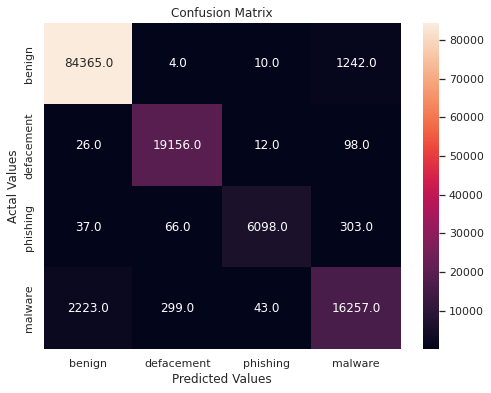

In [212]:
# RF Confusion matrix 
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

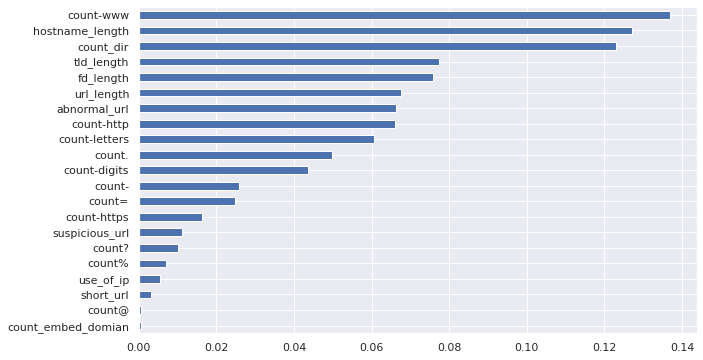

In [213]:
# RF feature importance
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

We see top 5 features importance are hostname_length, count-www, count_dir, count-http, fd_length.

- Light GBM Classifier

In [214]:

lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)

y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))
score = accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.97     19292
    phishing       0.97      0.89      0.92      6504
     malware       0.90      0.82      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.92      0.93    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.957


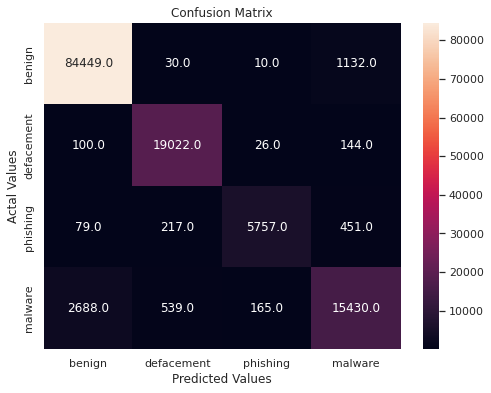

In [215]:
# Confusion matrix of Light GBM
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

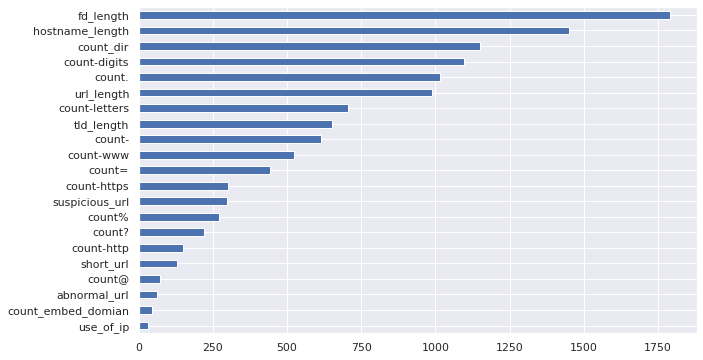

In [216]:
# feature importance of Light GBM classfier
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

We see top 5 features importance are fd_length, hostname_length, count_dir, count-digits, count.

- XGBoost Classifier

In [217]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))
score = accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.95      0.99      0.97     85621
  defacement       0.89      0.97      0.93     19292
    phishing       0.91      0.76      0.83      6504
     malware       0.88      0.73      0.80     18822

    accuracy                           0.93    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.93      0.93      0.93    130239

accuracy:   0.935


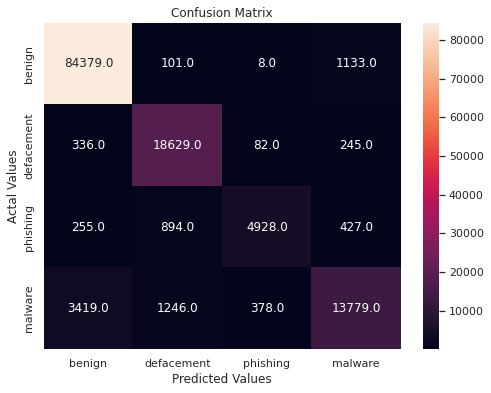

In [218]:
# Confusion matrix of XGBoost Classifier
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

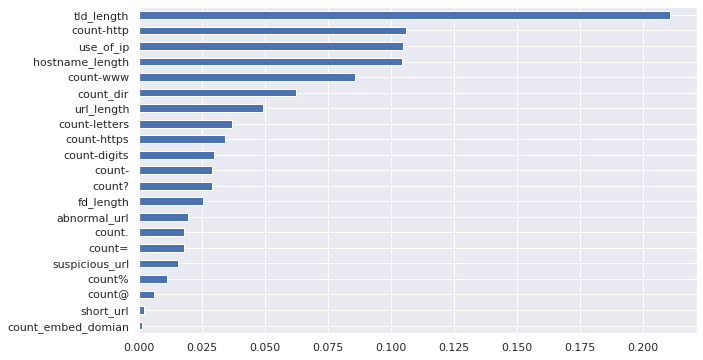

In [219]:
# feature importance of XGBoost classfier
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

We see top 5 features importance are tld_length, count-http, use_of_ip, hostname_length, count-www. 

In [220]:
model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               2816      
                                                                 
 batch_normalization_18 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_19 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 64)              

In [221]:
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [222]:
checkpointer = ModelCheckpoint('url.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)
history=model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpointer])

Epoch 1/10
2027/2035 [============================>.] - ETA: 0s - loss: 0.8829 - acc: 0.7093
Epoch 1: val_acc improved from -inf to 0.85387, saving model to url.h5
2035/2035 [==============================] - 15s 7ms/step - loss: 0.8816 - acc: 0.7097 - val_loss: 0.4009 - val_acc: 0.8539
Epoch 2/10
2032/2035 [============================>.] - ETA: 0s - loss: 0.4772 - acc: 0.8422
Epoch 2: val_acc improved from 0.85387 to 0.88976, saving model to url.h5
2035/2035 [==============================] - 16s 8ms/step - loss: 0.4771 - acc: 0.8422 - val_loss: 0.3174 - val_acc: 0.8898
Epoch 3/10
2031/2035 [============================>.] - ETA: 0s - loss: 0.3951 - acc: 0.8686
Epoch 3: val_acc improved from 0.88976 to 0.90818, saving model to url.h5
2035/2035 [==============================] - 14s 7ms/step - loss: 0.3951 - acc: 0.8686 - val_loss: 0.2779 - val_acc: 0.9082
Epoch 4/10
2033/2035 [============================>.] - ETA: 0s - loss: 0.3510 - acc: 0.8827
Epoch 4: val_acc improved from 0.9081

The training accuracy is 90% and validation accuracy is 92% after 10 epochs.

In [223]:
# create prediction and pick best model, i.e, random forest model
def main(url):
    
    status = []
    
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_percentage(url))
    status.append(count_question(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    return status    

In [224]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Convert feature test to  2D array 
    features_test = np.array(features_test).reshape((1, -1))
  
    pred = rf.predict(features_test)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res

In [225]:
# create some test URLs
urls=['https://logistilink.xyz',
      'https://iridescent-croquembouche-4b8508.netlify.app/',
      'apple-search.info',      
      'titaniumcorporate.co.za',
      'en.wikipedia.org/wiki/North_Dakota'
     ]

for url in urls:
  print(get_prediction_from_url(url))

MALWARE
MALWARE
MALWARE
MALWARE
SAFE


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with